To begin this model, I had to collect all of the necessary libraries. Throughout the course of my work on this project, I tested KMeans, DBSCAN, and AgglomerativeClustering. In the end, the most accurate in terms of ARI and NMI was the DBSCAN. 
Regardless, I used Pandas, Numpy, Scikit-Learn, Seaborn, and Matplotlib for the project, and imported them here.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
#from sklearn.cluster import AgglomerativeClustering
#from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Since the datasets were slightly off in their indentation and spacing, I created column names to divide each set into. I used a separator of '\s+' and skipped row 1, which was a bunch of hyphens as a separator. I read each Sensor text file independently, as A and B, then used Pandas to convert them into a dataframe using read_csv. Also, I had to specify the datetime format used by the dataset.

In [ ]:
column_names = ['Start', 'time', 'End', 'time.1', 'Location', 'Type', 'Place'] #Here I declared some column names - I used a separator to parse them better
sensors_A_df = pd.read_csv("../Project 2/UCI ADL Binary Dataset (2)/UCI ADL Binary Dataset/OrdonezA_Sensors.txt", sep=r'\s+', engine='python', skiprows=1, names=column_names)
sensors_B_df = pd.read_csv("../Project 2/UCI ADL Binary Dataset (2)/UCI ADL Binary Dataset/OrdonezB_Sensors.txt", sep=r'\s+', engine='python', skiprows=1, names=column_names)

datetime_format = "%Y-%m-%d %H:%M:%S" #This is the format used by the dataset

For both dataframes (referred to as Sensor A or B), I dropped any troublesome NaNs and calculated the start times and end times for each one. Then, using this, I could find the duration of any event.

In [ ]:
for df in [sensors_A_df, sensors_B_df]:
    df.dropna(subset=['Start', 'End'], inplace=True) #Here is where I dropped the NaNs
    df['Set'] = 'A' if df is sensors_A_df else 'B'
    df['Start time'] = pd.to_datetime(df['Start'] + ' ' + df['time'], format=datetime_format, errors='coerce') #Calculating start time
    df['End time'] = pd.to_datetime(df['End'] + ' ' + df['time.1'], format=datetime_format, errors='coerce') #Calculating end time
    df['Duration'] = (df['End time'] - df['Start time']).dt.total_seconds() #Calculating duration of the event

In my first attempts at this, I used a window-based system, and found each event within the time window. This didn't work well due to the large time differences in events, so I switched to an event-based system. 

I had pandas concatenate the datasets now, and drop the NaNs in start time. Then, I could sort them, and calculate things like the Time since the last event, and the previous sensor type. 

In [ ]:
sensors_all_df = pd.concat([sensors_A_df, sensors_B_df], ignore_index=True) #Here I combine both datasets for the sensors
sensors_all_df = sensors_all_df.dropna(subset=['Start time']) 
sensors_all_df = sensors_all_df.sort_values('Start time').reset_index(drop=True) #This is where they are sorted
sensors_all_df['TimeSinceLast'] = sensors_all_df['Start time'].diff().dt.total_seconds() #This is calculating the time for each event since the previous one
sensors_all_df['TimeSinceLast'] = sensors_all_df['TimeSinceLast'].fillna(0)
sensors_all_df['PrevSensorType'] = sensors_all_df['Type'].shift(1) #This shifts the type by 1 to find the previous type of sensor for each event
sensors_all_df['PrevSensorType'] = sensors_all_df['PrevSensorType'].fillna("None")

Next, I needed to choose my actual features, which I placed in another pandas datafram, called feature_df. I found each event's timestamp, duration, type, place, location, set (A or B), time since last event, and previous sensor type. These are the most relevant features I could find.

In [5]:
feature_df = pd.DataFrame({
    'Timestamp': sensors_all_df['Start time'],
    'Duration': sensors_all_df['Duration'],
    'Type': sensors_all_df['Type'],
    'Place': sensors_all_df['Place'],
    'Location': sensors_all_df['Location'],
    'Set': sensors_all_df['Set'],
    'TimeSinceLast': sensors_all_df['TimeSinceLast'],
    'PrevSensorType': sensors_all_df['PrevSensorType']
})

Now it is time for the labels/evaluation after clustering. I created two pandas dataframes for each respective label set, and for each one, I calculated its start, end, and finally, Activity (which is the actual label/answer).

In [ ]:
labels_df_A = pd.read_csv("../Project 2/UCI ADL Binary Dataset (2)/UCI ADL Binary Dataset/OrdonezA_ADLs.txt", sep=r"\s{2,}", skiprows=2, names=["Start", "End", "Activity"], engine="python") 
labels_df_B = pd.read_csv("../Project 2/UCI ADL Binary Dataset (2)/UCI ADL Binary Dataset/OrdonezB_ADLs.txt", sep=r"\s{2,}", skiprows=2, names=["Start", "End", "Activity"], engine="python")

for labels_df in [labels_df_A, labels_df_B]:
    labels_df["Start"] = pd.to_datetime(labels_df["Start"])
    labels_df["End"] = pd.to_datetime(labels_df["End"])
    labels_df["Activity"] = labels_df["Activity"].str.strip()


Next I made a function to get the activity for any timestamp for a specific user (AKA set, or A or B). For each row, I found the label for a specific start time in the respective dataframe, and its endtime. Unless it was Unknown, I had it return the Activity for comparison and evaluation.

In [7]:
def get_activity_for_timestamp_user(timestamp, user_set):
    labels_df = labels_df_A if user_set == 'A' else labels_df_B
    row = labels_df[(labels_df["Start"] <= timestamp) & (labels_df["End"] >= timestamp)]
    return row["Activity"].values[0] if not row.empty else "Unknown"


Finally, I had to make a small mapping for which room is which location (and therefore which 'Place' is which 'Location') so I could add them as relevant features.

In [ ]:
room_mapping = {
    'Shower': 'Bathroom',
    'Basin': 'Bathroom',
    'Cooktop': 'Kitchen',
    'Maindoor': 'Entrance',
    'Fridge': 'Kitchen',
    'Cabinet': 'Kitchen',
    'Cupboard': 'Kitchen',
    'Toilet': 'Bathroom',
    'Seat': 'Living',
    'Bed': 'Bedroom',
    'Microwave': 'Kitchen',
    'Toaster': 'Kitchen'
}

Now, I had to do the actual calculations to find each location, room, etc. Once that was done, I had to one-hot encode some values, as they were not numerical. I used Pandas' getdummies to do this.

In [ ]:
feature_df['Room'] = feature_df['Location'].map(room_mapping)
feature_df['Room'] = feature_df['Room'].astype('category').cat.codes #This is where I calculated which Room was cat.coded

feature_df['PrevTime'] = feature_df['Timestamp'].shift(1) #Previous Timestamp

feature_df['TimeBetweenActivations'] = (feature_df['Timestamp'] - feature_df['PrevTime']).dt.total_seconds()
feature_df['TimeBetweenActivations'] = feature_df['TimeBetweenActivations'].fillna(0) #Calculation for the time between sensor activations

feature_df['RoomOccupancy'] = feature_df.groupby('Room')['Timestamp'].transform(lambda x: x.diff().dt.total_seconds().sum())
feature_df['RoomOccupancy'] = feature_df['RoomOccupancy'].fillna(0) #The occupancy of the room per timestamp

feature_df['SensorActivationDuration'] = feature_df['Duration'] #The duration of any event

feature_df['PrevSensorType'] = feature_df['Type'].shift(1)
feature_df['PrevSensorType'] = feature_df['PrevSensorType'].astype('category').cat.codes #The cat.coded previous sensor type

feature_df['SensorTransition'] = feature_df['PrevSensorType'] + "_" + feature_df['Type'] #The transition sensor

feature_df['SensorFrequency'] = feature_df.groupby('Location')['Timestamp'].transform(lambda x: x.diff().dt.total_seconds().mean()) #Frequency of a given sensor

feature_df['Type'] = feature_df['Type'].astype('category').cat.codes #Type catcoded

feature_df['Place'] = feature_df['Place'].astype('category').cat.codes #Place catcoded

feature_df['Location'] = feature_df['Location'].astype('category').cat.codes #Location catcoded

feature_df['hour'] = feature_df['Timestamp'].dt.hour
feature_df['hour_sin'] = np.sin(2 * np.pi * feature_df['hour'] / 24)
feature_df['hour_cos'] = np.cos(2 * np.pi * feature_df['hour'] / 24) #Hour calculations for each day/night

feature_df['NextSensorType'] = feature_df['Type'].shift(-1).ffill() #The next sensor type

feature_df['SensorTypeChange'] = (feature_df['Type'] != feature_df['PrevSensorType']).astype(int)

feature_df['Activity'] = feature_df.apply(
    lambda row: get_activity_for_timestamp_user(row['Timestamp'], row['Set']), axis=1 #The label for each event
)
feature_df['SensorActivationCount'] = feature_df.groupby('Location')['Location'].transform('count') #The count of activation for each location sensor

sensor_type_ohe = pd.get_dummies(feature_df['Type'], prefix='SensorType') #The get dummies statement for one-hot encoding

feature_df = pd.concat([feature_df, sensor_type_ohe], axis=1) #Concatenating the one-hots with the feature dataframe for the final feature df

Now I need to actually encode the labels so I can see how accurate everything is upon evaluation. I make the encoder 'le', then create the feature columns to be displayed and evaluated. I then extend this array to the one-hots.

In [ ]:
le = LabelEncoder() #The encoder

feature_df['ActivityEncoded'] = le.fit_transform(feature_df['Activity']) #Creating which Activity is actually encoded

feature_cols = ['Type', 'Place', 'Location', 'Duration', 'hour', 'PrevSensorType', 'SensorFrequency', 'TimeBetweenActivations', 'NextSensorType', 'SensorTypeChange', 'hour_sin', 'hour_cos', 'SensorActivationCount'] #These are the actual displayed features from feature_df
feature_cols.extend(sensor_type_ohe.columns) #The one hots are brought in
print(feature_cols) #Prints the final feature columns for evaluation

['Type', 'Place', 'Location', 'Duration', 'hour', 'PrevSensorType', 'SensorFrequency', 'TimeBetweenActivations', 'NextSensorType', 'SensorTypeChange', 'hour_sin', 'hour_cos', 'SensorActivationCount', 'SensorType_0', 'SensorType_1', 'SensorType_2', 'SensorType_3', 'SensorType_4']


Now, everything must be scaled. If the values aren't scaled, the one-hots will be on a totally different weight/scale than everything else, and will either be drowned out in terms of relevance, or irrelevant. Therefore, I used StandardScaler to put everything on a relative scale of 0-1 with a standard dev of 1. Once that is done, it is ready for clustering. I tested many different eps and min_samples values, but the optimal ones for this feature array and using DBSCAN was ~2.2 eps and 4 min_samples. I used sklearn to calculate the ARI and NMI, which are between -1 to 1, and will help represent my accuracy with the clusters. The closer to 1, the better (negative is worse than random guessing).

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_df[feature_cols]) #Here I scale everything so it is all relevant

eps = 2.2 #I tested many values, this was best result
min_samples = 4 #I tested many values, this was best result

dbscan = DBSCAN(eps=eps, min_samples=min_samples) #this runs DBSCAN to find some cluster predictions
feature_df['Cluster'] = dbscan.fit_predict(X_scaled)

ari = adjusted_rand_score(feature_df["ActivityEncoded"], feature_df["Cluster"]) #ARI
nmi = normalized_mutual_info_score(feature_df["ActivityEncoded"], feature_df["Cluster"]) #NMI

print(f"ARI: {ari:.3f}, NMI: {nmi:.3f}, eps = {eps}, min_samples = {min_samples}")

ARI: 0.320, NMI: 0.399, eps = 2.2, min_samples = 4


An ARI and NMI of 0.320 and 0.399 respectively was the best result I achieved throughout my testing. With this in mind, I used seaborn and matplotlib to get a confusion matrix, so I could understand the results a bit better. I also used a mask to hide the unknowns for a better visual.

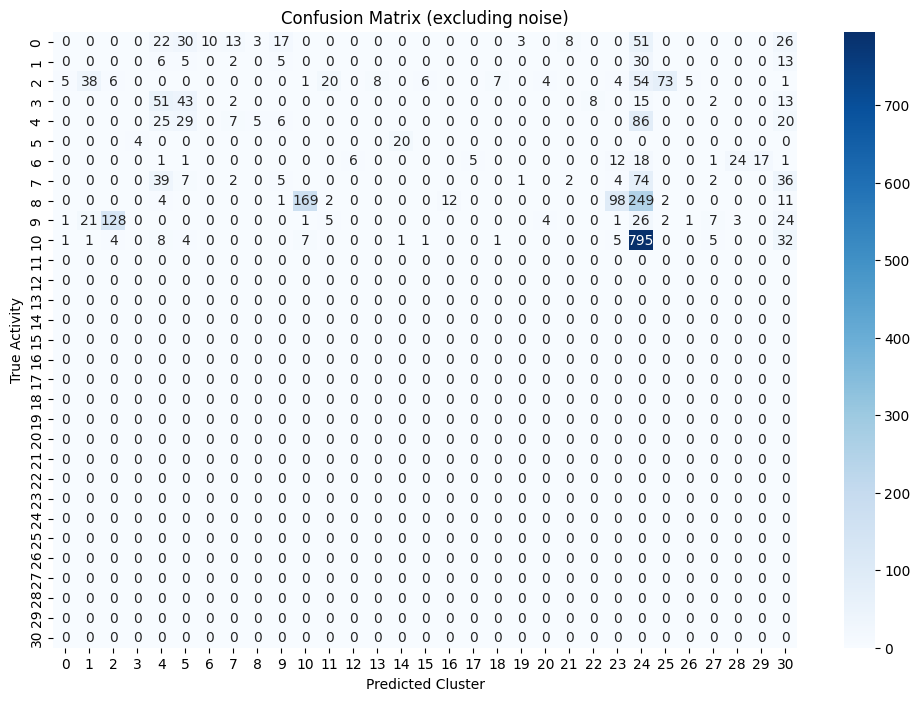

In [ ]:
y_true = feature_df["ActivityEncoded"]
y_pred = feature_df["Cluster"]

mask = y_pred != -1 #Mask
conf_matrix = confusion_matrix(y_true[mask], y_pred[mask]) #Generates the confusion matrix

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix (excluding noise)")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Activity")
plt.show()

Once that was done, I wanted to use PCA to better see how everything was being represented, and how accurate the predictions were. I did the typical PCA setup and plotted in matplotlib. Both the testing and ground-truth answers are displayed for comparison.

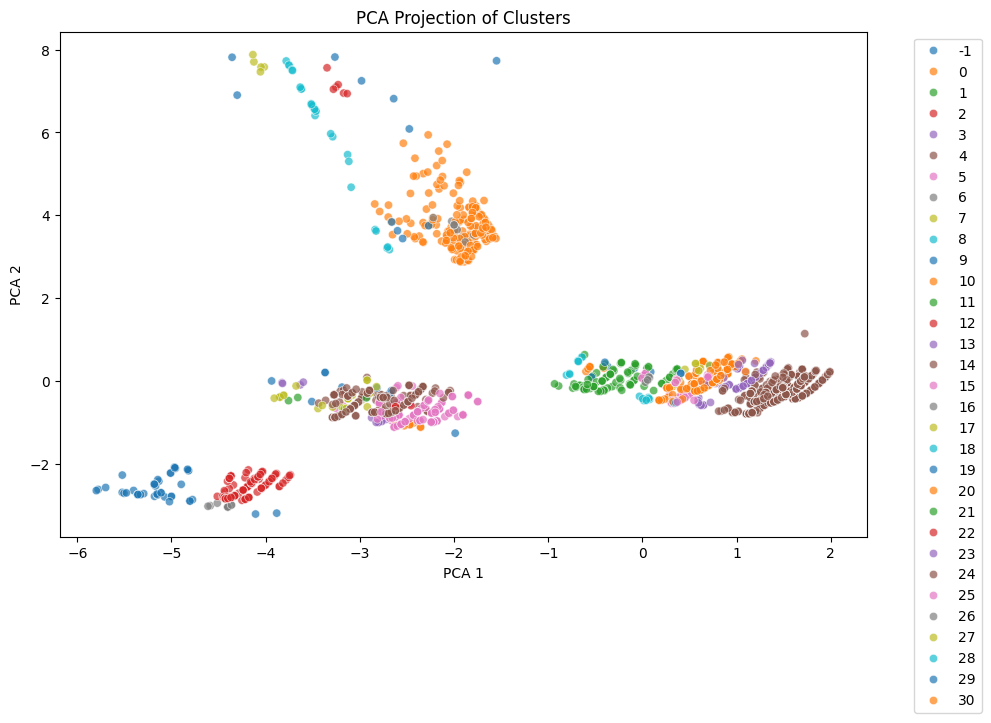

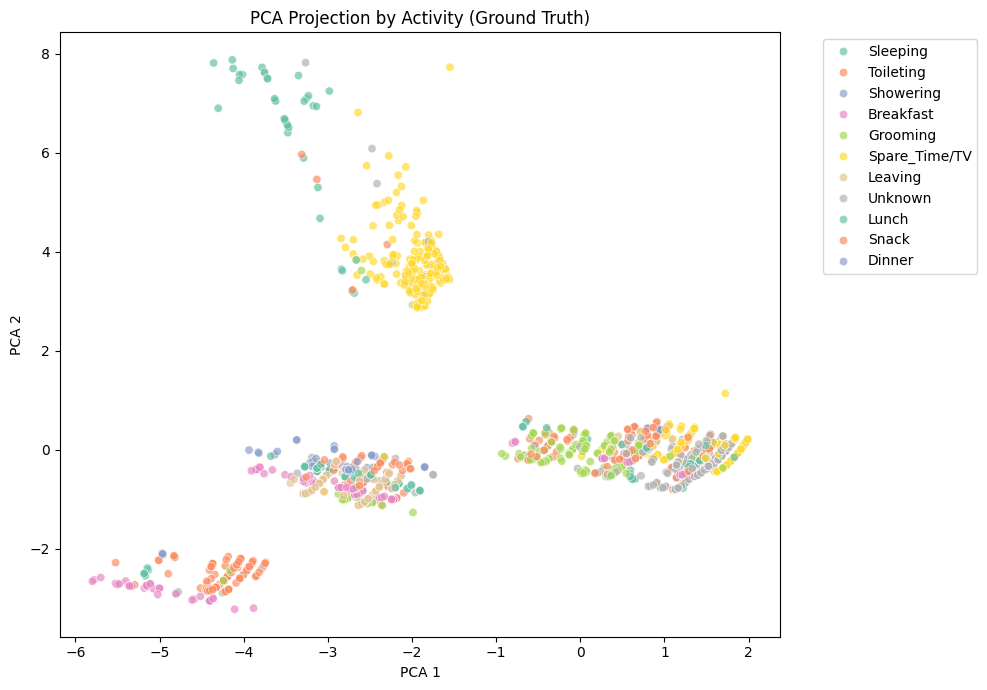

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) #PCA setup, as normal

feature_df['PCA1'] = X_pca[:, 0] #Create PCA 1 from some features
feature_df['PCA2'] = X_pca[:, 1] #PCA 2 to complement it

plt.figure(figsize=(10, 7))
sns.scatterplot( #Plot in Seaborn
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='tab10',
    data=feature_df,
    legend='full',
    alpha=0.7
)
plt.title("PCA Projection of Clusters") #This is my guess projection
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Activity',
    palette='Set2',
    data=feature_df,
    legend='full',
    alpha=0.7
)
plt.title("PCA Projection by Activity (Ground Truth)") #These are the actual labels
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


I wanted a heatmap to evaluate which features may be redundant. It was successful, and in earlier trials I ended up removing some irrelevant or harmful features. This is the modern one, displayed below, calculated using seaborn and matplotlib, like above.

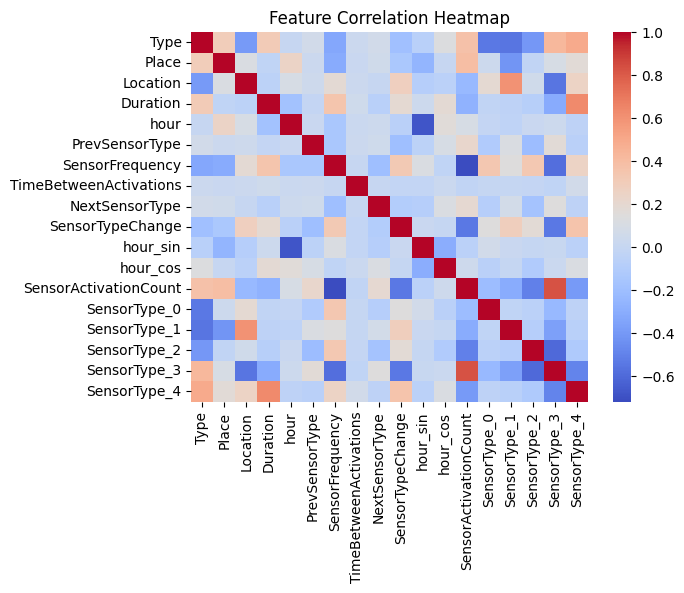

In [14]:
corr_matrix = pd.DataFrame(X_scaled, columns=feature_cols).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()
